<div align="center">
    
# Логистическая регрессия  
## Моделирование вероятностей классов с помощью логистической регрессии

</div>

---

Основные принципы **логистической регрессии** как вероятностной модели для бинарной классификации:

- **Линейная комбинация признаков**:  
  $$ z = \mathbf{w}^\top \mathbf{x} + b $$  
  где $z$ затем подается на сигмоидную функцию.
  
- **Роль весов**:  
  Каждый коэффициент $w_i$ показывает, как изменение признака $x_i$ на единицу влияет на логарифм шансов (log‑odds).  
  $$ \Delta\log\frac{p}{1-p} = w_i\;\Delta x_i $$

- **Роль смещения (bias)**:  
  $b$ задаёт «базовый» лог‑относительный шансы при всех $x_i = 0$, то есть смещает разделяющую гиперплоскость.

- **Использование шансов** (odds) для оценки вероятности наступления события.

- **Логит‑функция**, представляющая собой логарифм отношения шансов:  
  $$ \text{logit}(p) = \ln\left(\frac{p}{1 - p}\right) $$

- **Обратная логиту функция** (сигмоидная функция), которая переводит логиты обратно в вероятность:  
  $$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

- **Функция потерь** — логарифмическая (log‑loss) или перекрестная энтропия:  
  $$ L(\hat p, y) = -\left[y \cdot \ln(\hat p) + (1 - y) \cdot \ln(1 - \hat p)\right] $$

- **Градиентный спуск** для обновления параметров:  
  $$
    w_i \leftarrow w_i - \eta \frac{\partial L}{\partial w_i}, \quad
    b   \leftarrow b   - \eta \frac{\partial L}{\partial b}
  $$
  где $\eta$ — скорость обучения.

- **Регуляризация** (L1, L2) помогает избежать переобучения и управлять сложностью модели.

- **Порог классификации**: по умолчанию $p = 0.5$, но его можно настраивать для балансировки precision/recall.


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [23]:
class LogisticRegressionGD:
    """Классификатор Логистической регрессии
    
    Параметры
    ----------
    eta : float  # Скорость обучения (между 0.0 и 1.0)
    n_iter : int  # Кол-во проходов по обучающему набору
    random_state : int  # затравка генератора случайных чисел для инициализации весов случайным значением

    Атрибуты
    ---------
    w_ : одномерный массив # Веса после подгонки
    b_ : скаляр # Смещение после подгонки
    losses_: list # Значение среднеквадратичной функции потерь после каждой эпохи
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta 
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Подгонка к обучающим данным

        Параметры
        ----------
        X : {array-like}, shape = [n_examples, n_features] # Обучающие векторы, где n_examples - кол-во образцов, а  n_feature - кол-во признаков
        y : array-like, shape = [n_examples] # Целевые переменные
        
        Возвращаемые значения
        ----------
        self : object 
        """

        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc = 0.0, scale = 0.01, size = X.shape[1])
        self.b_ = np.float64(0.0)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output)) # Это классическая лог‑потеря (кросс‑энтропия)
                   - ((1 - y).dot(np.log(1 - output)))
                   / X.shape[0])
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Вычисление фактического входа"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, z):
        """Вычисление логистической сигмоидной активации"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Возвращаем метку класса"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)    

Так как модель логистической регресии работает толлько для задач бинарной классификации, то мы рассмотрим цветки setosa и versicolor (классы 0 и 1).

In [24]:
# 1) Загрузка и фильтрация двух классов
iris = datasets.load_iris()
X_all = iris.data
y_all = iris.target
mask01 = (y_all == 0) | (y_all == 1)

# 2) Выбор нужных фич: колонки 3 и 4 (sepal length, sepal width)
X_01 = X_all[mask01][:, [2, 3]]
y_01 = y_all[mask01]

# 3) Стандартизация 
X_std = np.copy(X_01)
X_std[:, 0] = (X_01[:, 0] - X_01[:, 0].mean()) / X_01[:, 0].std()
X_std[:, 1] = (X_01[:, 1] - X_01[:, 1].mean()) / X_01[:, 1].std()


# 4) Обучение на двух признаках
lgrd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lgrd.fit(X_std, y_01)

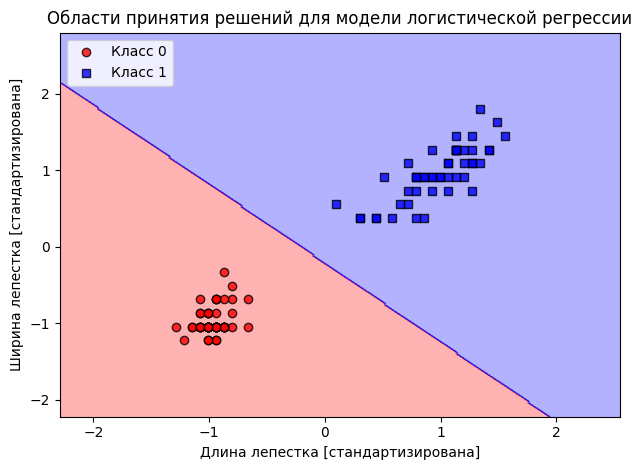

In [25]:
# График визуализации областей принятия решений Logistic Regression
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha = 0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Построение образцов класса
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                   y = X[y == cl, 1],
                   alpha=0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=f'Класс {cl}',
                   edgecolor='black')

plot_decision_regions(X=X_std, y=y_01, classifier=lgrd)
plt.xlabel('Длина лепестка [стандартизирована]')
plt.ylabel('Ширина лепестка [стандартизирована]')
plt.title('Области принятия решений для модели логистической регрессии')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Теперь после того, как мы посмотрели начинку логистической регрессии, можно перейти к обучению на основе библиотеки scikit-learn, которая в свою очередь поддерживает многоклассовую классификацию - мультиномиальный или OvR. `multi_class` по умолчанию будет выбрано автоматически («auto»), что эквивалентно OVR на двух классах и «multinomial» на трёх и более, в зависимости от солвера.

In [26]:
# 1) Загрузка всех образцов Iris
iris   = datasets.load_iris()
X_all_2  = iris.data        # shape (150, 4)
y_all_2  = iris.target      # shape (150,)

# 2) Выбор двух признаков: petal length (индекс 2) и petal width (индекс 3)
X_23   = X_all_2[:, [2, 3]]

# 3) Стандартизация признаков
scaler = StandardScaler()
X_std_2  = scaler.fit_transform(X_23)

# Делим X_std_2 и y_all_2 на train и test
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_std_2, y_all_2, np.arange(len(y_all_2)),
    test_size=0.3,          # 30% тест
    random_state=1,
    stratify=y_all_2        # сохраняем пропорции классов
)

lr = LogisticRegression(C = 100.0, solver = 'lbfgs')
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,100.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


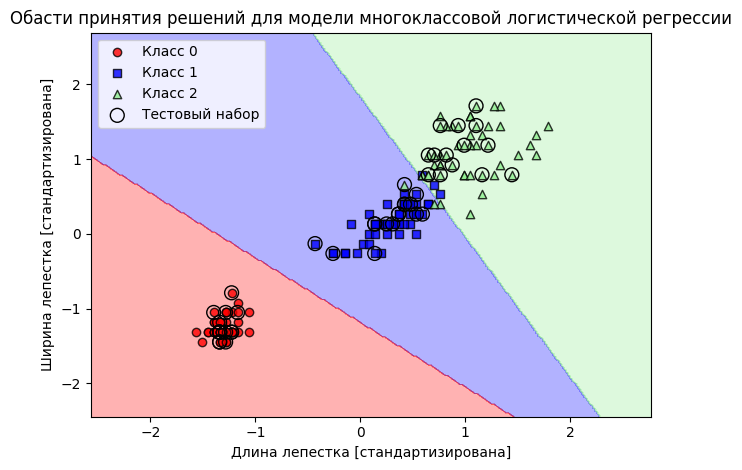

In [27]:
# График визуализации областей принятия решений Logistic Regression
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap    = ListedColormap(colors[:len(np.unique(y))])

    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Отрисовка всех образцов
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f'Класс {cl}',
            edgecolor='black'
        )

    # Подсветка тестовых образцов, если переданы индексы
    if test_idx is not None:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            X_test[:, 0], X_test[:, 1],
            facecolors='none',
            edgecolors='black',
            alpha=1.0,
            linewidth=1,
            marker='o',
            s=100,
            label='Тестовый набор'
        )



plot_decision_regions(
    X=np.vstack((X_train, X_test)),
    y=np.hstack((y_train, y_test)),
    classifier=lr,
    test_idx=range(len(X_train), len(X_train) + len(X_test))
)
plt.xlabel('Длина лепестка [стандартизирована]')
plt.ylabel('Ширина лепестка [стандартизирована]')
plt.title('Обасти принятия решений для модели многоклассовой логистической регрессии')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
print("Коэффициенты модели:\n", lr.coef_)
print("Смещения (intercepts):\n", lr.intercept_)
print("Accuracy на test : {:.2f}".format(lr.score(X_test,  y_test)))

# Вероятности для первых трёх тестовых образцов
print("Индексы этих образцов в исходном массиве:", idx_test[:3])
print("Predict_proba для них:\n", lr.predict_proba(X_test[:3, :]))

Коэффициенты модели:
 [[-6.94373356e+00 -5.78281592e+00]
 [-1.94668324e+00 -1.79255162e-03]
 [ 8.89041680e+00  5.78460847e+00]]
Смещения (intercepts):
 [-1.01981045  5.83028433 -4.81047388]
Accuracy на test : 0.98
Индексы этих образцов в исходном массиве: [148   5   6]
Predict_proba для них:
 [[8.90921968e-13 3.86996204e-04 9.99613004e-01]
 [9.93804412e-01 6.19558848e-03 1.05069843e-15]
 [9.98759166e-01 1.24083381e-03 1.54811200e-17]]


### Борьба с переобучением

---

**Переобучение** - распространенная проблема в машинном обучении, это означает, что модель хорошо работает на обучающих данных, но плохо обобщается на незнакомые данные. Если модель страдает от переобучения, то она имеет высокую дисперсию, которая может быть вызвана наличием большого кол-ва параметров, то есть модель слишком сложна по отношению к исходным данным. Точно так же наша модель может страдать от **недообучения**, когда она не достаточно сложна, чтобы хорошо выявлять закономерности в обучающих данных и следовательно обладает низкой обобщающей способностью на незнакомых данных. 

Для разрешения этой проблемы существует компромисс - точная настройка сложности модели с помощью **регуляризации**. Это очень полезный инструмент, для устранения колллинеарности (высокой корреляции между признаками), фильтрации шума и предотвращения переобучения. Идея регуляризации заключается в том, чтобы ввести дополнительную информацию для штрафа за экстремальные значения параметров (весов). Распространенная регуляризация: L2, так называемая затуханием веса.

Чтобы регуляризация работала должным образом, нужно убедиться, что все признаки имеют сопоставимые масштабы (провести стандартизацию).

Именно поэтому мы провели стандартизацию признаков и применили параметр регуляризации `C` в нашей модели `LogisticRegression`. Почему был выбран параметр `C = 100`? Значение C=100 достаточно велико, чтобы штраф за большие коэффициенты был почти незаметен. Это ближе к «чистой» (нерегуляризованной) логистической регрессии, когда мы хотим дать модели свободу подстроиться под данные, так как набор данных Iris, имеет хорошо разделимую выборку с не большим объемом данных.  


